# Exemplo processamento sinal flare

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from atmospheric_lidar import licelv2
import glob
import os
#from atmospheric_lidar.licel import LicelLidarMeasurement
from lifa.licel import LicelLidarMeasurement
import json


## Carrega arquivos a serem processados

In [2]:
# Diretorio com dados
directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Meio chama p=23mm bom pra caralho"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima flare fast"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima da chama p=23 mm"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Topo chama p-23mm"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Em baixo chama p 23"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Meio chama p=23mm bom pra caralho"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Topo chama p-23mm"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima da chama p=23 mm"

file_wildcard = 'a???????.??????'
files = glob.glob(os.path.join(directory, file_wildcard))

measurement_all = LicelLidarMeasurement(files)

print("Numero de arquivos: {} ".format(len(files)))
print("Canais: {}".format(measurement_all.channels.keys()))
print("Dimensoes dados: {}".format(measurement_all.channels['00355.o_an'].matrix.shape))

Numero de arquivos: 61 
Canais: odict_keys(['00355.o_an', '00355.o_std_an', '00355.o_ph', '00355.o_std_ph', '00395.s_an', '00395.s_std_an', '00395.s_ph', '00395.s_std_ph', '00353.o_an', '00353.o_std_an', '00353.o_ph', '00353.o_std_ph', '00371.o_an', '00371.o_std_an', '00371.o_ph', '00371.o_std_ph', '00395.p_an', '00395.p_std_an', '00395.p_ph', '00395.p_std_ph', '00460.o_an', '00460.o_std_an', '00460.o_ph', '00460.o_std_ph', '00532.o_an', '00532.o_std_an', '00532.o_ph', '00532.o_std_ph', '00530.o_an', '00530.o_std_an', '00530.o_ph', '00530.o_std_ph'])
Dimensoes dados: (61, 16380)


In [3]:
measurement_all.channels['00355.o_an'].start_time
measurement_all.channels['00355.o_an'].stop_time

datetime.datetime(2024, 12, 5, 5, 43, 26, tzinfo=<UTC>)

## Função para processamento

In [4]:
def emissions(files, calib):


    measurement_all = LicelLidarMeasurement(files)
    licel_channels_names = ['00355.o_an', '00353.o_an',  '00371.o_an', '00395.s_an', '00395.p_an', '00460.o_an', '00532.o_an', '00530.o_an']
    licel_channels_id = {k: v for v, k in enumerate(licel_channels_names)}
    measurement = measurement_all.subset_by_channels(licel_channels_names)

    # Range correction
    for channel in licel_channels_names:
        measurement.channels[channel].calculate_rc()

    # Build raw signal and range corrected matrix
    raw_signal = []
    rc_signal = []
    distance = []
    hv = []
    start_time = []
    stop_time = []
    for channel in licel_channels_names:
        raw_signal.append(np.mean(measurement.channels[channel].matrix, axis=0))
        rc_signal.append(np.mean(measurement.channels[channel].rc, axis=0))
        distance.append(measurement.channels[channel].z)
        hv.append(measurement.channels[channel].hv)
        start_time.append(measurement.channels[channel].start_time)
        stop_time.append(measurement.channels[channel].stop_time)


    raw_signal =np.array(raw_signal)
    rc_signal = np.array(rc_signal)
    # assume distance is the same for all channels
    distance = np.array(distance)[0]
    # assume voltage is the same all files
    hv = np.array(hv)[:,0]
    # Asssume start/stop time is the same all channels and files
    start_time = start_time[0]
    stop_time = stop_time[0]

    # raw_signal é melhor que range corrected pq evidencia sinais mais próximos do lidar. Melhor para visualizar pequenos sinais
    # Retira background
    signal = raw_signal
    #bin_min = -1000
    #bin_max = -500
    background_bins = calib['background_bins']
    background = np.mean(raw_signal[:,background_bins], axis=1)
    signal = np.transpose(np.transpose(raw_signal) - background)

    #clipa na região de interesse
    pre_flare_bins = calib['pre_flare_bins']
    post_flare_bins = calib['post_flare_bins']
    subset_min = pre_flare_bins[0]
    subset_max = post_flare_bins[1]
    signal_subset = signal[:,subset_min:subset_max]
    distance_subset = distance[subset_min:subset_max]

    # Calcula sinal de referencia
    # Avaliação de crosstalk entre 355 e 352. Ver que exite influencia. O mesmo não ocorre em 532 e 530 nm.
    #bin_shift = 0
    #crosstalk = 150
    crosstalk = calib['crosstalk_355_ref']

    ref_signal = signal_subset[licel_channels_id['00353.o_an']] - (1/crosstalk)*signal_subset[licel_channels_id['00355.o_an']]

    # Seleciona região da curva para fitting. Pegar depois de pico
    #bin_min = None
    #bin_max = None
    #fit_idx = np.concatenate((x[:2], x[-2:]))
    #xfit = distance_subset[bin_min:bin_max]
    pre_len = pre_flare_bins[1] - pre_flare_bins[0]
    post_len = post_flare_bins[1] - post_flare_bins[0]
    
    # região de fitting é somente pre e post flame
    xfit = np.concatenate( (distance_subset[:pre_len], distance_subset[-post_len:]) )
    ydata = np.concatenate( (ref_signal[:pre_len], ref_signal[-post_len:]) )



    #ydata = ref_signal[bin_min:bin_max]


    z = np.polyfit(xfit, ydata, 10)
    f = np.poly1d(z)

    fit_ref = f(distance_subset)

    # Fluorescencia
    # Fluorescence indicator 460/ref
    fluo = signal_subset[licel_channels_id['00460.o_an']]/fit_ref

    # CO2 = (371)/ref
    #gco2 = 3e6
    gco2 = calib['g_co2']
    #gfluo_co2 = 0.00235
    #gfluo_co2 = 0.0
    gfluo_co2 = calib['crosstalk_fluo_co2']
    co2 = gco2*((signal_subset[licel_channels_id['00371.o_an']])/fit_ref - gfluo_co2*fluo)

    # CO2 = (371)/ref
    #gch4 = 0.5e6
    gch4 = calib['g_ch4']
    #gdif_ch4 = 0
    gdif_ch4 = calib['g_sp_ch4']
    #gfluo_ch4 = 0
    gfluo_ch4 = calib['crosstalk_fluo_ch4']

    # Forma 1
    ch4_1 = gch4*((signal_subset[licel_channels_id['00395.p_an']] - gdif_ch4*signal_subset[licel_channels_id['00395.s_an']])/fit_ref)
    # Forma 2
    ch4_2 = gch4*(signal_subset[licel_channels_id['00395.p_an']]/fit_ref - gfluo_ch4*fluo)

    ch4= ch4_1

    #ce = 1 /(1 + ch4/(co2 + ch4))
    ce_1 = co2/(co2 + ch4)
    g_ce_rel = 0.16
    ce_2 = 1/(1 + (g_ce_rel*signal_subset[licel_channels_id['00395.p_an']]/signal_subset[licel_channels_id['00371.o_an']]))

    ce = ce_1

    flare_bins = calib['flare_bins']
    rel_idx_min = flare_bins[0] - subset_min
    rel_idx_max = flare_bins[1] - subset_min
    flare_co2 = calib['correction_factor_co2']*np.mean(co2[rel_idx_min:rel_idx_max])
    flare_ch4 = calib['correction_factor_ch4']*np.mean(ch4[rel_idx_min:rel_idx_max])
    flare_ce = flare_co2/(flare_ch4 + flare_co2)
    flare_ce_rel = np.mean(ce_2[rel_idx_min:rel_idx_max])
    flare_fluo = calib['correction_factor_fluo']*np.mean(fluo[rel_idx_min:rel_idx_max])

    rel_idx_min = 0
    rel_idx_max = pre_flare_bins[1] - subset_min
    pre_flare_co2 = np.mean(co2[rel_idx_min:rel_idx_max])
    pre_flare_ch4 = np.mean(ch4[rel_idx_min:rel_idx_max])
    pre_flare_ce = pre_flare_co2/(pre_flare_ch4 + pre_flare_co2)
    pre_flare_ce_rel = np.mean(ce_2[rel_idx_min:rel_idx_max])
    pre_flare_fluo = np.mean(fluo[rel_idx_min:rel_idx_max])

    output = {
        'diagnostics' :
        {
            'calibrations': calib,
            'files': files,
            'channels': licel_channels_names,
            'hv': hv,
            'signal': signal,
            'background': background,
            'reference': ref_signal,
            'fitting': fit_ref,
            'fluorescence': fluo,
            'co2': co2,
            'ch4': ch4,
            'ce': ce,
            'ce_rel': ce_2,
            'distances': distance,
            'start_time': start_time,
            'stop_time': stop_time
        },
        'pre_flare' : {
            'co2': pre_flare_co2,
            'ch4': pre_flare_ch4,
            'ce': pre_flare_ce,
            'ce_rel' : pre_flare_ce_rel, 
            'fluo': pre_flare_fluo,
        },
        'flare' : {
            'co2': flare_co2,
            'ch4': flare_ch4,
            'ce': flare_ce,
            'ce_rel': flare_ce_rel,
            'fluo': flare_fluo
        }
    }

    return output

## Exemplo de processamento

In [5]:
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Em baixo chama p 23"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Meio chama p=23mm bom pra caralho"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Topo chama p-23mm"
directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima da chama p=23 mm"

file_wildcard = 'a???????.??????'
files = glob.glob(os.path.join(directory, file_wildcard))

# Parametros de calibração
calibrations = {
    'crosstalk_355_ref': 150,           # valor de crosstalk de 355 nm no sinal de 353 nm
    'g_co2': 3e6,                       # ganho do canal 371
    'crosstalk_fluo_co2': 0,            # crosstalk da fluorescencia no 371
    'g_ch4': 0.5e6,                     # ganho do canal 395 nm
    'crosstalk_fluo_ch4': 0,            # crosstalk da fluorescencia no 395 nm
    'g_sp_ch4': 0,                      # fator de correção entre 395p e 395 s. A ideia é que um tem fluorescencia+raman e outro somente fluorescencia
    'g_ce_relative': 0.16,              # fator de correção para ce calculado diretamente por 1/(1 +(g * raman ch4/raman co2))
    'pre_flare_bins': (80,100),         # região antes do flare para uso de referencia
    'post_flare_bins': (120,140),       # região após flare e oscilação pmt para referência
    'flare_bins': (104,109),            # posição do flare
    'background_bins': (15000, 16000),  # região onde é calculado background do sinal
    'correction_factor_co2': 1,         # fator de correção devido limitação resolução espacial para CO2
    'correction_factor_ch4': 1,         # fator de correção devido limitação resolução espacial para CH4
    'correction_factor_fluo': 1         # fator de correção devido limitação resolução espacial para FLUO
}

flare_emissions = emissions(files=files[:], calib = calibrations)

## Dados para flare

In [6]:
print("Flare: ")
print("CO2 {:.0f} ppm".format(flare_emissions['flare']['co2']))
print("CH4 {:.0f} ppm".format(flare_emissions['flare']['ch4']))
print("CE {:.1f} %".format(100*flare_emissions['flare']['ce']))
print("CE (razao raman) {:.1f} %".format(100*flare_emissions['flare']['ce_rel']))

Flare: 
CO2 1431 ppm
CH4 35 ppm
CE 97.6 %
CE (razao raman) 97.4 %


## Diagnostico

In [7]:
# Apresenta informações
print('Numero de arquivos: {}'.format(len(flare_emissions['diagnostics']['files'])))
print('PMTs Voltage {}'.format(flare_emissions['diagnostics']['hv']))
print('Backgrounds {}'.format(flare_emissions['diagnostics']['background']))
print('Flare: ',flare_emissions['flare'])
print('Pre flare: ',flare_emissions['pre_flare'])

Numero de arquivos: 18
PMTs Voltage [754. 756. 759. 754. 752. 755. 754. 754.]
Backgrounds [5.20361512 5.49888633 5.48184794 5.53405164 5.55022952 5.54619624
 5.35259962 5.58832817]
Flare:  {'co2': np.float64(1431.0093897042996), 'ch4': np.float64(35.302369576814186), 'ce': np.float64(0.975924376686359), 'ce_rel': np.float64(0.9741013024176134), 'fluo': np.float64(0.021057189417224065)}
Pre flare:  {'co2': np.float64(389.9436163626855), 'ch4': np.float64(5.685221425432241), 'ce': np.float64(0.9856299114664715), 'ce_rel': np.float64(0.986316329712969), 'fluo': np.float64(0.0010394681458769353)}


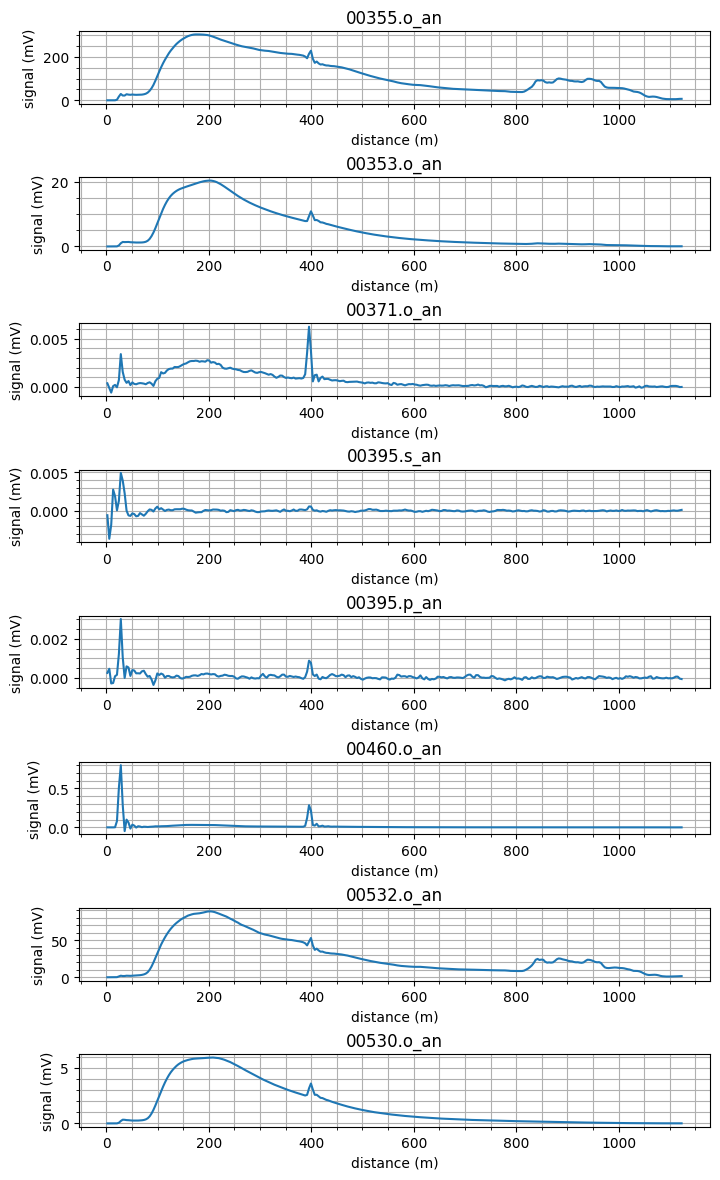

In [8]:
# Sinal PMTs
signal = flare_emissions['diagnostics']['signal']
distance = flare_emissions['diagnostics']['distances']
channels = flare_emissions['diagnostics']['channels']
bin_min = 0
bin_max = 300
cm = 1/2.54
#fig, axes = plt.subplots(3, 1, figsize=(18*cm,29.7*cm), layout='constrained') # (width, height) in inches
#fig = plt.figure(figsize=(18*cm, 29.7*cm))
fig, ax = plt.subplots(nrows=len(signal), figsize=(18*cm,29.7*cm), layout='constrained')
for i,trace in enumerate(signal):
    ax[i].plot(distance[bin_min:bin_max], trace[bin_min:bin_max])
    ax[i].set_title(channels[i])
    ax[i].grid(True, 'both')
    ax[i].minorticks_on()
    ax[i].set_xlabel('distance (m)')
    ax[i].set_ylabel('signal (mV)')

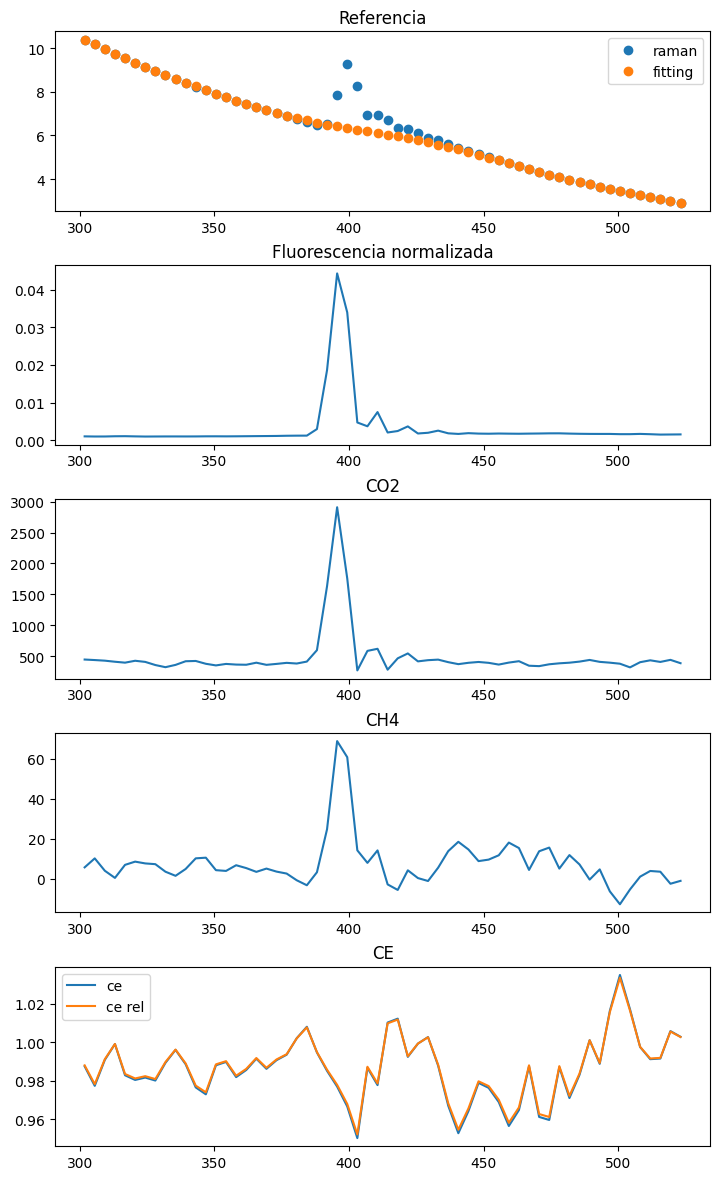

In [9]:
# Sinal processado
bin_min = flare_emissions['diagnostics']['calibrations']['pre_flare_bins'][0]
bin_max = flare_emissions['diagnostics']['calibrations']['post_flare_bins'][1]
distance = flare_emissions['diagnostics']['distances'][bin_min:bin_max]

fig, ax = plt.subplots(nrows=5, figsize=(18*cm,29.7*cm), layout='constrained')

#for i,trace in enumerate(signal):
#    ax[i].plot(distance[bin_min:bin_max], trace[bin_min:bin_max])
#    ax[i].set_title(channels[i])
#    ax[i].grid(True, 'both')
#    ax[i].minorticks_on()
#    ax[i].set_xlabel('distance (m)')
#    ax[i].set_ylabel('signal (mV)')

ax_ref = ax[0]
ax_fluo = ax[1]
ax_co2 = ax[2]
ax_ch4 = ax[3]
ax_ce = ax[4]

ax_ref.plot(distance, flare_emissions['diagnostics']['reference'], 'o', label='raman')
ax_ref.plot(distance, flare_emissions['diagnostics']['fitting'], 'o', label='fitting')
ax_ref.set_title('Referencia')
ax_ref.legend()

ax_fluo.plot(distance, flare_emissions['diagnostics']['fluorescence'])
ax_fluo.set_title('Fluorescencia normalizada')

ax_co2.plot(distance, flare_emissions['diagnostics']['co2'])
ax_co2.set_title('CO2')

ax_ch4.plot(distance, flare_emissions['diagnostics']['ch4'])
ax_ch4.set_title('CH4')


ax_ce.set_title('CE')
ax_ce.plot(distance, flare_emissions['diagnostics']['ce'], label='ce')
ax_ce.plot(distance, flare_emissions['diagnostics']['ce_rel'], label='ce rel')
ax_ce.legend()


#plt.title('CE Relativo')
#plt.plot(flare_emissions['diagnostics']['ce_rel'])

## Exemplo Dashboard

Text(0, 0.5, 'FLUO')

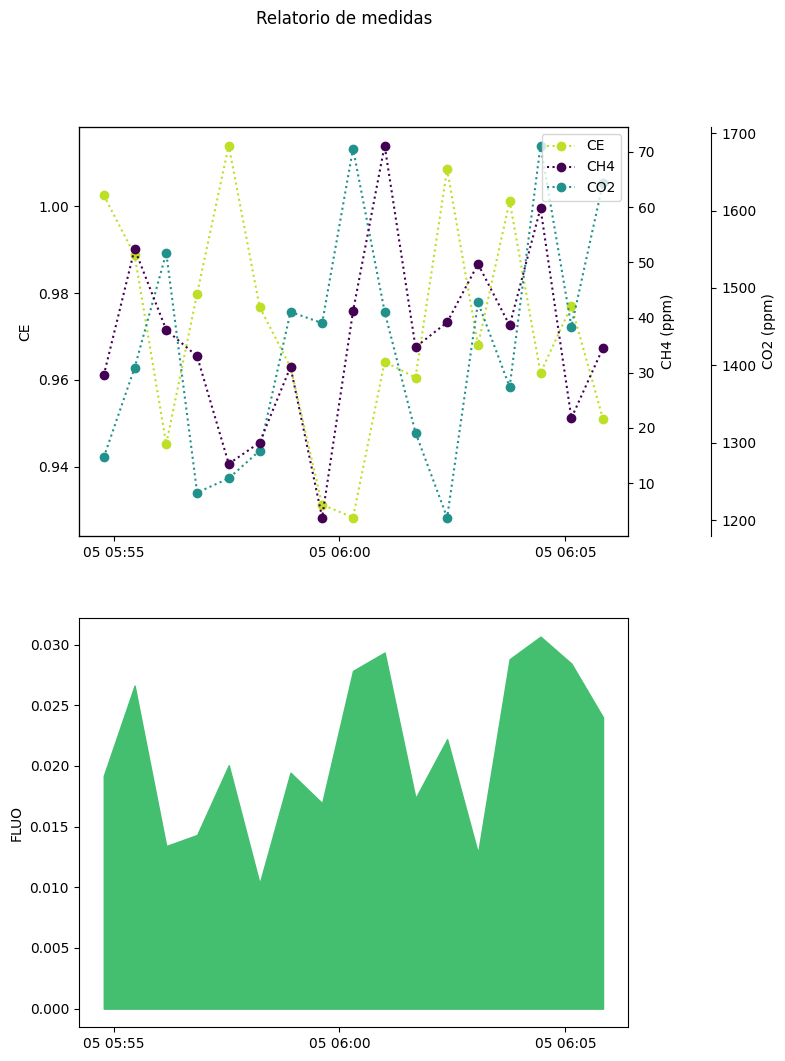

In [11]:
directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima da chama p=23 mm"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Topo chama p-23mm"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Em baixo chama p 23"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Meio chama p=23mm bom pra caralho"

file_wildcard = 'a???????.??????'
files = glob.glob(os.path.join(directory, file_wildcard))

measurement_all = LicelLidarMeasurement(files)

# Alimenta mais de um arquivo por vez (para fazer media) se desejado (block>1)
step = 1    # tamanho do passo - quantos arquivos ele pula em cada passo
block = 1   # qauntos arquivos deixa no mesmo bloco - faz média - tipo boxcar
files_block = []
for x in range(0,len(files)-block,step):
    files_block.append(files[x:x+block])

# Parametros de calibração
calibrations = {
    'crosstalk_355_ref': 150,           # valor de crosstalk de 355 nm no sinal de 353 nm
    'g_co2': 3e6,                       # ganho do canal 371
    'crosstalk_fluo_co2': 0,            # crosstalk da fluorescencia no 371
    'g_ch4': 0.5e6,                     # ganho do canal 395 nm
    'crosstalk_fluo_ch4': 0,            # crosstalk da fluorescencia no 395 nm
    'g_sp_ch4': 0,                      # fator de correção entre 395p e 395 s. A ideia é que um tem fluorescencia+raman e outro somente fluorescencia
    'g_ce_relative': 0.16,              # fator de correção para ce calculado diretamente por 1/(1 +(g * raman ch4/raman co2))
    'pre_flare_bins': (80,100),         # região antes do flare para uso de referencia
    'post_flare_bins': (120,140),       # região após flare e oscilação pmt para referência
    'flare_bins': (104,109),            # posição do flare
    'background_bins': (15000, 16000),  # região onde é calculado background do sinal
    'correction_factor_co2': 1,         # fator de correção devido limitação resolução espacial para CO2
    'correction_factor_ch4': 1,         # fator de correção devido limitação resolução espacial para CH4
    'correction_factor_fluo': 1         # fator de correção devido limitação resolução espacial para FLUO
}


medidas = []
ce = []
co2 = []
ch4 = []
fluo = []
time = []
for block in files_block:
    e = emissions(files=block, calib = calibrations)
    medidas.append(e)
    ce.append(e['flare']['ce_rel'])
    co2.append(e['flare']['co2'])
    ch4.append(e['flare']['ch4'])
    fluo.append(e['flare']['fluo'])
    time.append(e['diagnostics']['start_time'])


# Plota

cm = 1/2.54
#fig, axes = plt.subplots(3, 1, figsize=(18*cm,29.7*cm), layout='constrained') # (width, height) in inches
fig = plt.figure(figsize=(18*cm, 29.7*cm))

fig.suptitle("Relatorio de medidas")

fig1 = fig.subfigures(1, 1)
#figL, figR = fig.subfigures(2, 1, height_ratios=[2, 1])

ax, ax2 = fig1.subplots(2,1)
axes = [ax, ax.twinx(), ax.twinx()]



ax_co2 = axes[2]
ax_ch4 = axes[1]
ax_ce = axes[0]
ax_fluo = ax2


color1, color2, color3, color4 = plt.cm.viridis([0, .5, .9, .7])

p2 = ax_co2.plot(time, co2, color=color1, label="CH4", marker='o', linestyle=':')
p3 = ax_ch4.plot(time, ch4, color=color2, label="CO2", marker='o', linestyle=':')
p1 = ax_ce.plot(time, ce, color=color3, label="CE", marker='o', linestyle=':')
ax_fluo.fill_between(time, fluo, color=color4, label="FLUO")

ax_co2.legend(handles=p1+p2+p3, loc='best')

ax_co2.spines['right'].set_position(('outward', 60))

ax_ch4.set_ylabel("CH4 (ppm)")
ax_co2.set_ylabel("CO2 (ppm)")
ax_ce.set_ylabel("CE")
ax_fluo.set_ylabel("FLUO")